# Kernel setup (RAM boost + install Keras 2.1.0)

In [0]:
!pip install  keras==2.1.0

In [0]:
import keras

In [0]:
keras.__version__

'2.1.0'

In [0]:
#this will clear all the GPU RAM
#!pkill -9 -f ipykernel_launcher

In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.2 GB  | Proc size: 5.9 GB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


# 1. Autoencoder

In [0]:
from keras.utils.conv_utils import normalize_data_format
from keras.datasets import mnist
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
import io, gzip, requests, gc
from keras.utils import np_utils
from keras.applications import VGG16
from keras.preprocessing import image
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import np_utils
import matplotlib.pyplot as plt
import io, gzip, requests, gc
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array, array_to_img
plt.viridis()
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU

In [0]:
#Prepare your data:

#For MINIST
#(x_train, _), (x_test, _) = mnist.load_data()
#x_train = x_train.astype('float32') / 255.
#x_test = x_test.astype('float32') / 255.
#x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
#x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

train_image_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz"
train_label_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz"
test_image_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz"
test_label_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz"

def readRemoteGZipFile(url, isLabel=True):
    response=requests.get(url, stream=True)
    gzip_content = response.content
    fObj = io.BytesIO(gzip_content)
    content = gzip.GzipFile(fileobj=fObj).read()
    if isLabel:
        offset=8
    else:
        offset=16
    result = np.frombuffer(content, dtype=np.uint8, offset=offset)    
    return(result)

train_labels = readRemoteGZipFile(train_label_url, isLabel=True)
train_images_raw = readRemoteGZipFile(train_image_url, isLabel=False)
test_labels = readRemoteGZipFile(test_label_url, isLabel=True)
test_images_raw = readRemoteGZipFile(test_image_url, isLabel=False)

train_images = train_images_raw.reshape(len(train_labels), 784)
test_images = test_images_raw.reshape(len(test_labels), 784)
Y_train = train_labels
Y_test = test_labels

X_train = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
X_test = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

X_train /= 255
X_test /= 255

X_train *= 2.
X_test *= 2.

Y_train = np_utils.to_categorical(Y_train, 10)
Y_test = np_utils.to_categorical(Y_test, 10)

In [0]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')],
                verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 160us/step - loss: -1.3777 - val_loss: -1.7851
Epoch 2/50
60000/60000 [==============================] - 7s 114us/step - loss: -1.8505 - val_loss: -1.9135
Epoch 3/50
60000/60000 [==============================] - 7s 114us/step - loss: -1.9502 - val_loss: -1.9863
Epoch 4/50
60000/60000 [==============================] - 7s 114us/step - loss: -2.0057 - val_loss: -1.9980
Epoch 5/50
60000/60000 [==============================] - 7s 114us/step - loss: -2.0423 - val_loss: -2.0494
Epoch 6/50
60000/60000 [==============================] - 7s 114us/step - loss: -2.0664 - val_loss: -2.0379
Epoch 7/50
60000/60000 [==============================] - 7s 114us/step - loss: -2.0813 - val_loss: -2.0812
Epoch 8/50
60000/60000 [==============================] - 7s 115us/step - loss: -2.0956 - val_loss: -2.0989
Epoch 9/50
60000/60000 [==============================] - 7s 114us/step - loss: -2.10

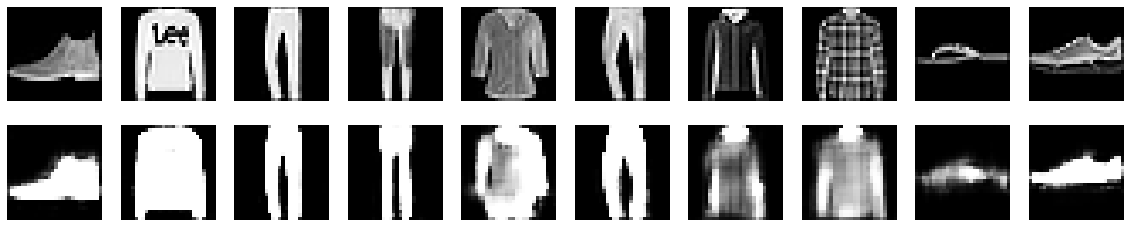

In [0]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 2. Image Classification

## 2.1    Deep CNN

In [0]:
from keras.applications import VGG16
from keras.preprocessing import image
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import np_utils
import matplotlib.pyplot as plt
import io, gzip, requests, gc
plt.viridis()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/15
60000/60000 [==============================] - 8s 127us/step - loss: 0.5987 - acc: 0.7908
Epoch 2/15
60000/60000 [==============================] - 6s 108us/step - loss: 0.4019 - acc: 0.8570
Epoch 3/15
60000/60000 [==============================] - 6s 108us/step - loss: 0.3447 - acc: 0.8780
Epoch 4/15
60000/60000 [==============================] - 7s 108us/step - loss: 0.3149 - acc: 0.8872
Epoch 5/15
60000/60000 [==============================] - 6s 108us/step - loss: 0.2897 - acc: 0.8960
Epoch 6/15
60000/60000 [==============================] - 7s 109us/step - loss: 0.2738 - acc: 0.9001
Epoch 7/15
60000/60000 [==============================] - 7s 109us/step - loss: 0.2557 - acc: 0.9067
Epoch 8/15
60000/60000 [==============================] - 7s 109us/step - loss: 0.2464 - acc: 0.9098
Epoch 9/15
60000/60000 [======================

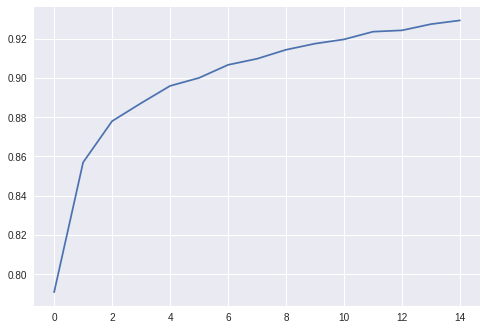

In [0]:
model = Sequential()
model.add(Conv2D(filters = 32,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid',
                 input_shape=(28,28,1)))
model.add(Conv2D(filters = 32,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_training = model.fit(X_train, Y_train,
          epochs=15,
          batch_size=128,
         verbose = 1)

plt.plot(model_training.history["acc"])

In [0]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 111us/step
Test loss: 0.22695973647534848
Test accuracy: 0.9231


## 2.2 Transfer Learning

Reference: https://www.kaggle.com/anandad/classify-fashion-mnist-with-vgg16

In [0]:
#Previously:


#train_image_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz"
#train_label_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz"
#test_image_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz"
#test_label_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz"

#def readRemoteGZipFile(url, isLabel=True):
#    response=requests.get(url, stream=True)
#    gzip_content = response.content
#    fObj = io.BytesIO(gzip_content)
#    content = gzip.GzipFile(fileobj=fObj).read()
#    if isLabel:
#        offset=8
#    else:
#        offset=16
#    result = np.frombuffer(content, dtype=np.uint8, offset=offset)    
#    return(result)

#train_labels = readRemoteGZipFile(train_label_url, isLabel=True)
#train_images_raw = readRemoteGZipFile(train_image_url, isLabel=False)
#test_labels = readRemoteGZipFile(test_label_url, isLabel=True)
#test_images_raw = readRemoteGZipFile(test_image_url, isLabel=False)

#train_images = train_images_raw.reshape(len(train_labels), 784)
#test_images = test_images_raw.reshape(len(test_labels), 784)
#Y_train = train_labels
#Y_test = test_labels

X_train_trans = np.dstack([train_images] * 3)
X_test_trans = np.dstack([test_images]*3)

X_train_trans = X_train_trans.reshape(-1, 28, 28, 3)
X_test_trans= X_test_trans.reshape (-1, 28, 28, 3)

X_train_trans = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_train_trans])
X_test_trans = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in X_test_trans])

X_train_trans /= 255
X_test_trans /= 255

X_train_trans = X_train_trans.astype('float32')
X_test_trans = X_test_trans.astype('float32')

Y_train_trans = np_utils.to_categorical(Y_train, 10)
Y_test_trans = np_utils.to_categorical(Y_test, 10)

In [0]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_label, valid_label = train_test_split(X_train_trans,
                                                           Y_train_trans,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )
train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)
test_X  = preprocess_input (X_test_trans)

In [0]:
train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [0]:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

In [0]:
from keras.applications import VGG16
from keras import optimizers
conv_base = VGG16(weights = "imagenet", include_top = False, input_shape = (48, 48, 3))
# Extracting features
train_features = conv_base.predict(np.array(train_X), batch_size = BATCH_SIZE, verbose = 1)
test_features = conv_base.predict(np.array(test_X), batch_size = BATCH_SIZE, verbose = 1)
val_features = conv_base.predict(np.array(valid_X), batch_size = BATCH_SIZE, verbose = 1)

12000/12000 [==============================] - 13s 1ms/step


In [0]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (48000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (12000, 1*1*512))

In [0]:
# 7.0 Define the densely connected classifier followed by leakyrelu layer and finally dense layer for the number of classes
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100

model = models.Sequential()

first_dense = layers.Dense(512, activation='relu', input_dim=(1*1*512))
first_dense.trainable = False
model.add(first_dense)

relu_layer = layers.LeakyReLU(alpha=0.1)
relu_layer.trainable = False
model.add(relu_layer)

model.add(layers.Dense(10, activation='softmax'))

In [0]:
# Compile the model.
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
  # optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

In [0]:
# Incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

In [0]:
model_trans = model.fit(
    train_features_flat,
    train_label,
    epochs=200,
    validation_data=(val_features_flat, valid_label),
    verbose = 1,
    callbacks=callbacks
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 10s 213us/step - loss: 0.8392 - acc: 0.6975 - val_loss: 0.9302 - val_acc: 0.6452
Epoch 2/200
48000/48000 [==============================] - 10s 209us/step - loss: 0.8440 - acc: 0.6946 - val_loss: 0.8942 - val_acc: 0.6803
Epoch 3/200
48000/48000 [==============================] - 10s 208us/step - loss: 0.8406 - acc: 0.6973 - val_loss: 0.8502 - val_acc: 0.6974
Epoch 4/200
48000/48000 [==============================] - 10s 203us/step - loss: 0.8389 - acc: 0.6960 - val_loss: 0.8455 - val_acc: 0.6992
Epoch 5/200
48000/48000 [==============================] - 10s 203us/step - loss: 0.8343 - acc: 0.6976 - val_loss: 0.8222 - val_acc: 0.7062
Epoch 6/200
48000/48000 [==============================] - 9s 191us/step - loss: 0.8383 - acc: 0.6982 - val_loss: 0.8215 - val_acc: 0.7039
Epoch 7/200
48000/48000 [==============================] - 9s 192us/step - loss: 0.8374 - acc: 0.6976 - val_los

# 3. Text Classification

Inspiration: https://github.com/incertum/cyber-matrix-ai/tree/master/Malicious-URL-Detection-Deep-Learning

About how to use Keras's Tokenizer funciton: https://github.com/rstudio/keras/issues/336

About how to use Keras's pad_sequence function: https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/

About 1D CNN: https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

##  3.1    RNN

In [0]:
benign_url = "https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt"
benign = requests.get(benign_url).content.decode('utf-8').split('\n')

bad_url = "https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt"
bad = requests.get(bad_url).content.decode('utf-8').split('\n')

In [0]:
len(benign)

66057

In [0]:
len(bad)

1297

This is a very imbalanced dataset. Down sample Benign url set to keep same length with bad url set.

In [0]:
import random
random.seed(1120)  
benign_train = random.sample(benign, len(bad))
bad_train = bad
train = benign_train + bad_train
lable = np.array([1] * len(bad) + [0] * len(bad))
print(len(train), len(lable))

2594 2594


(array([126., 938., 531., 696., 185.,  91.,  22.,   1.,   2.,   2.]),
 array([ 0. ,  8.6, 17.2, 25.8, 34.4, 43. , 51.6, 60.2, 68.8, 77.4, 86. ]),
 <a list of 10 Patch objects>)

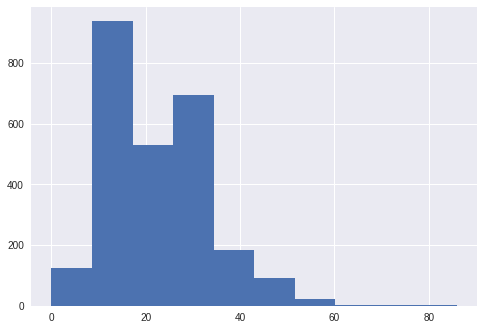

In [0]:
plt.hist([len(i) for i in train])

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(train)
sequences = tokenizer.texts_to_sequences(train)
maxlen = max([len(i) for i in train])
train_padseq = pad_sequences(sequences, maxlen = maxlen) 

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_padseq, lable, test_size=0.2, random_state=42)

In [0]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2075, 86), (2075,), (519, 86), (519,))

In [0]:
num_char = len(tokenizer.word_index)

In [0]:
from keras.preprocessing import sequence
from keras.layers import Dense, SimpleRNN, LSTM, Embedding
rnn_model = Sequential()
rnn_model.add(Embedding(50, 64))
rnn_model.add(SimpleRNN(32))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

rnn_model.fit(X_train, y_train, epochs=50, batch_size=256, verbose = 1)

Epoch 1/50
2075/2075 [==============================] - 1s 462us/step - loss: 0.6155 - acc: 0.6848
Epoch 2/50
2075/2075 [==============================] - 0s 219us/step - loss: 0.5118 - acc: 0.8048
Epoch 3/50
2075/2075 [==============================] - 1s 249us/step - loss: 0.4512 - acc: 0.8260
Epoch 4/50
2075/2075 [==============================] - 1s 254us/step - loss: 0.4282 - acc: 0.8270
Epoch 5/50
2075/2075 [==============================] - 1s 243us/step - loss: 0.3750 - acc: 0.8636
Epoch 6/50
2075/2075 [==============================] - 1s 250us/step - loss: 0.3452 - acc: 0.8766
Epoch 7/50
2075/2075 [==============================] - 1s 251us/step - loss: 0.3193 - acc: 0.8853
Epoch 8/50
2075/2075 [==============================] - 1s 252us/step - loss: 0.3015 - acc: 0.8867
Epoch 9/50
2075/2075 [==============================] - 1s 247us/step - loss: 0.3118 - acc: 0.8795
Epoch 10/50
2075/2075 [==============================] - 1s 250us/step - loss: 0.2724 - acc: 0.9099
Epoch 11/

In [0]:
from sklearn.metrics import roc_curve
rnn_model.evaluate(X_test, y_test) #98% accuracy, pretty good. 

519/519 [==============================] - 0s 841us/step


[0.07764389887021456, 0.9865125241996235]

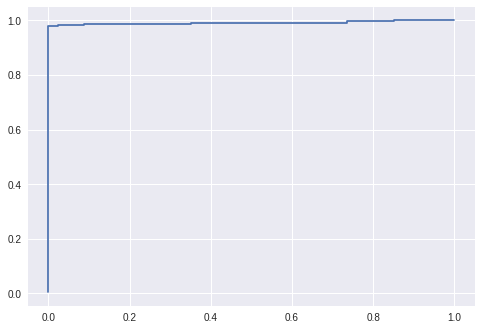

In [0]:
pred_rnn = rnn_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pred_rnn)
plt.plot(fpr, tpr)
plt.show() 

In [0]:
from sklearn import metrics
print("For RNN the AUC is: " + str(round(metrics.auc(fpr, tpr),2)))

For RNN the AUC is: 0.99


Very good performance on RNN.

## 3.2 CNN 1D

Data Prep into 3d for CNN: http://debajyotidatta.github.io/nlp/deep/learning/word-embeddings/2016/11/27/Understanding-Convolutions-In-Text/

Use method in paper: https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/

In [0]:
#our data:
train[:10], lable[:10]

(['.r8---sn-q4f7snly.googlevideo.com',
  '.ca-systest6045.us.oracle.com',
  '.r13---sn-4g57kned.googlevideo.com',
  '.mts.google.com',
  '.baymsg1010823.gateway.edge.messenger.live.com',
  '.sharepointppe.partners.extranet.microsoft.com',
  '.accoun.microsoft.com',
  '.gcaapp.iad2.secureserver.net',
  '.b2bapisit2.partners.extranet.microsoft.com',
  '.cgbusvn.us.oracle.com'],
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

Since CNN1D only adapt 3d input, we have to convert our input into a 3d tensor, unlike with RNN a 2d matrix

Model input shape:

RNN: num_url x padded_maxlen

CNN1D: num_url x padded_maxlen x num_chars (This is just the one-hot encoding by all unique characters in all training urls.)

In [0]:
txt = ''
for doc in train: #concatinate all benign/bad urls into one string
    for s in doc:
        txt += s
chars = set(txt)
vocab_size = len(chars)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 63


In [0]:
from keras.utils import to_categorical
def vectorize_sentences(train, char_indices):
    X = []
    for url in train:
        x = [char_indices[w] for w in url]
        x2 = np.eye(len(char_indices))[x]
        X.append(x2)
    return (pad_sequences(X))

train_data = vectorize_sentences(train, char_indices)
X_train_cnn1d, X_test_cnn1d, y_train_cnn1d, y_test_cnn1d = train_test_split(train_data, lable, test_size=0.2, random_state=42)

In [0]:
X_train_cnn1d.shape #looking good!

(2075, 86, 63)

In [0]:
y_train_cnn1d.shape

(2075,)

In [0]:
from keras.layers import Conv1D, MaxPooling1D, Dropout, Embedding
n_timesteps, n_features, n_outputs = X_train.shape[0], X_train.shape[1], y_train.shape[0]

cnn1d_model = Sequential()
cnn1d_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn1d.shape[1], X_train_cnn1d.shape[2])))
cnn1d_model.add(Dropout(0.5))
cnn1d_model.add(MaxPooling1D(pool_size = 2))
cnn1d_model.add(Flatten())
cnn1d_model.add(Dense(1, activation = 'sigmoid'))
cnn1d_model.compile(optimizer = "rmsprop", loss='binary_crossentropy', metrics = ["acc"])
#cnn1d_model.summary()
cnn1d_model.fit(X_train_cnn1d, y_train_cnn1d, epochs = 50, batch_size = 256, verbose = 1)

Epoch 1/50
2075/2075 [==============================] - 1s 537us/step - loss: 0.6252 - acc: 0.6178
Epoch 2/50
2075/2075 [==============================] - 0s 55us/step - loss: 0.5259 - acc: 0.7981
Epoch 3/50
2075/2075 [==============================] - 0s 52us/step - loss: 0.4657 - acc: 0.8096
Epoch 4/50
2075/2075 [==============================] - 0s 51us/step - loss: 0.4218 - acc: 0.8227
Epoch 5/50
2075/2075 [==============================] - 0s 53us/step - loss: 0.3928 - acc: 0.8313
Epoch 6/50
2075/2075 [==============================] - 0s 55us/step - loss: 0.3683 - acc: 0.8419
Epoch 7/50
2075/2075 [==============================] - 0s 54us/step - loss: 0.3514 - acc: 0.8578
Epoch 8/50
2075/2075 [==============================] - 0s 51us/step - loss: 0.3366 - acc: 0.8612
Epoch 9/50
2075/2075 [==============================] - 0s 50us/step - loss: 0.3193 - acc: 0.8684
Epoch 10/50
2075/2075 [==============================] - 0s 51us/step - loss: 0.3016 - acc: 0.8752
Epoch 11/50
2075/2

In [0]:
cnn1d_model.evaluate(X_test_cnn1d, y_test_cnn1d) #lower than RNN

519/519 [==============================] - 0s 511us/step


[0.11250215504670188, 0.9807321773788144]

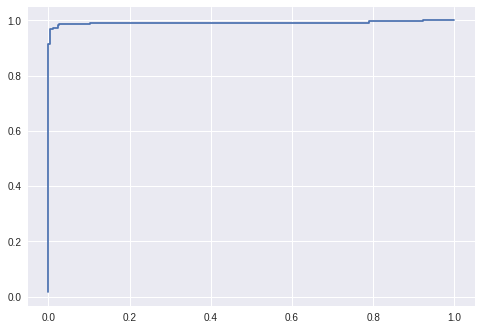

In [0]:
from sklearn.metrics import roc_curve
pred_cnn1d = cnn1d_model.predict(X_test_cnn1d)
fpr_cnn1d, tpr_cnn1d, ___ = roc_curve(y_test_cnn1d, pred_cnn1d)
plt.plot(fpr_cnn1d, tpr_cnn1d)
plt.show() 

In [186]:
from sklearn import metrics
print("For RNN the AUC is: " + str(round(metrics.auc(fpr, tpr),2)))
print("For CNN1D the AUC is: " + str(round(metrics.auc(fpr_cnn1d, tpr_cnn1d),2)))

For RNN the AUC is: 0.99
For CNN1D the AUC is: 0.99


To compare both method for character-wise text sequence classificastion for malicioius url detection, we have to refer to the area under the ROC curve. The AUC for both method is 0.99, indicsating that they both achieve similarly high result. 